# Sberbank Russian Housing Market

In [123]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Importing data

Train data

In [124]:
train_df = pd.read_csv('./data/train.csv', parse_dates=['timestamp'])
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

## Data cleansing


### Check mistakes and NaNs

- floor <= max_floor
- life_sq <= full_sq
- kitch_sq <= full_sq

Let's firstly check it on train data

In [125]:
# floor <= max_floor
wrong_max_floor = train_df['floor'] > train_df['max_floor']
display(train_df[wrong_max_floor][['floor', 'max_floor']])
# lets fix it
for index, row in train_df.iterrows():    
    if row['floor'] > row['max_floor']:
        train_df.loc[index, 'max_floor'] = row['floor']
display(train_df[wrong_max_floor][['floor', 'max_floor']])


,floor,max_floor
8216,13.0,0.0
8268,3.0,1.0
8499,2.0,0.0
8531,7.0,0.0
8912,5.0,0.0
...,...,...
30398,5.0,1.0
30400,3.0,0.0
30426,1.0,0.0
30439,12.0,0.0


,floor,max_floor
8216,13.0,13.0
8268,3.0,3.0
8499,2.0,2.0
8531,7.0,7.0
8912,5.0,5.0
...,...,...
30398,5.0,5.0
30400,3.0,3.0
30426,1.0,1.0
30439,12.0,12.0


In [126]:
nan_max_floor = train_df['max_floor'].isna()
display(train_df[nan_max_floor][['floor', 'max_floor']])
# lets fix it
for index, row in train_df.iterrows():    
    if np.isnan(row['max_floor']):
        train_df.loc[index, 'max_floor'] = row['floor']
display(train_df[nan_max_floor][['floor', 'max_floor']])

,floor,max_floor
0,4.0,NaN
1,3.0,NaN
2,2.0,NaN
3,9.0,NaN
4,4.0,NaN
...,...,...
10290,2.0,NaN
10304,4.0,NaN
10328,14.0,NaN
10389,15.0,NaN


,floor,max_floor
0,4.0,4.0
1,3.0,3.0
2,2.0,2.0
3,9.0,9.0
4,4.0,4.0
...,...,...
10290,2.0,2.0
10304,4.0,4.0
10328,14.0,14.0
10389,15.0,15.0


In [127]:
# life_sq <= full_sq
wrong_full_sq = train_df['life_sq'] > train_df['full_sq']
display(train_df[wrong_full_sq][['life_sq', 'full_sq']])

# lets fix it
for index, row in train_df.iterrows():    
    if row['life_sq'] > row['full_sq']:
        train_df.loc[index, 'full_sq'] = row['life_sq']
display(train_df[wrong_full_sq][['life_sq', 'full_sq']])

,life_sq,full_sq
1084,281.0,44
1188,44.0,9
1822,38.0,18
1863,178.0,30
2009,40.0,5
4385,426.0,73
6336,191.0,37
6531,88.0,80
6993,77.0,73
7208,195.0,31


,life_sq,full_sq
1084,281.0,281
1188,44.0,44
1822,38.0,38
1863,178.0,178
2009,40.0,40
4385,426.0,426
6336,191.0,191
6531,88.0,88
6993,77.0,77
7208,195.0,195


While checking kitch_sq I've found that kitch_sq has values of build year

In [128]:
train_df[train_df['build_year'] > 1400]['build_year'].min()

1691.0

In [129]:
train_df[train_df['build_year'] > 2020]['build_year']

10089    20052009.0
15220        4965.0
Name: build_year, dtype: float64

In [130]:
train_df.loc[15223, 'build_year'] = 2007 
train_df.loc[10092, 'build_year'] = 2007 


Minimum appropriate build_year is 1691

In [131]:
display(train_df[train_df['kitch_sq'] > 1691][['kitch_sq', 'build_year']])

# let's replace NaN
train_df.loc[13120, 'build_year'] = 1970
display(train_df[train_df['kitch_sq'] > 1691][['kitch_sq', 'build_year']])

,kitch_sq,build_year
10368,2013.0,2013.0
13117,1970.0,NaN
21415,2014.0,2014.0
28734,1974.0,1972.0


,kitch_sq,build_year
10368,2013.0,2013.0
13117,1970.0,NaN
21415,2014.0,2014.0
28734,1974.0,1972.0


In [132]:
# kitch_sq <= full_sq
wrong_kitch_sq = train_df['kitch_sq'] > train_df['full_sq']
display(train_df[wrong_kitch_sq][['kitch_sq', 'full_sq', 'life_sq']])

# lets fix it
for index, row in train_df.iterrows():    
    if row['kitch_sq'] > row['full_sq']:
        train_df.loc[index, 'kitch_sq'] = row['full_sq'] - row['life_sq']
display(train_df[wrong_kitch_sq][['kitch_sq', 'full_sq', 'life_sq']])


,kitch_sq,full_sq,life_sq
8056,12.0,11,11.0
9172,73.0,37,19.0
10368,2013.0,79,41.0
11520,620.0,38,23.0
12245,33.0,22,14.0
13117,1970.0,31,19.0
21415,2014.0,43,43.0
23216,44.0,43,29.0
26236,84.0,34,16.0
26850,86.0,38,20.0


,kitch_sq,full_sq,life_sq
8056,0.0,11,11.0
9172,18.0,37,19.0
10368,38.0,79,41.0
11520,15.0,38,23.0
12245,8.0,22,14.0
13117,12.0,31,19.0
21415,0.0,43,43.0
23216,14.0,43,29.0
26236,18.0,34,16.0
26850,18.0,38,20.0


In [133]:
# kitch_sq <= full_sq
nan_kitch_sq = train_df['kitch_sq'].isna()
display(train_df[nan_kitch_sq])

# lets fix it
for index, row in train_df.iterrows():
    if np.isnan(row['full_sq']):
        continue
    if np.isnan(row['kitch_sq']):
        if np.isnan(row['life_sq']):
            train_df.loc[index, 'life_sq'] = row['full_sq'] * 0.8
            train_df.loc[index, 'kitch_sq'] = row['full_sq'] * 0.2
        else:
            train_df.loc[index, 'kitch_sq'] = row['full_sq'] - row['life_sq']
display(train_df[nan_kitch_sq])

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

Check mistakes in categorical data

In [134]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Name", "Count"]
display(dtype_df.groupby("Count").aggregate('count').reset_index())

dtype_df.columns = ["Name", "Type"]
display(dtype_df[dtype_df['Type'] == 'object'])

,Count,Name
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


,Name,Type
11,product_type,object
12,sub_area,object
29,culture_objects_top_25,object
33,thermal_power_plant_raion,object
34,incineration_raion,object
35,oil_chemistry_raion,object
36,radiation_raion,object
37,railroad_terminal_raion,object
38,big_market_raion,object
39,nuclear_reactor_raion,object


In [135]:
train_df['sub_area'].value_counts()

Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: sub_area, Length: 146, dtype: int64

So, there is no problems in naming of categorical data

In [136]:
train_df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

## Trend Analysis

Let's see how the median housing price change with time.

In [138]:
train_df['yearmonth'] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

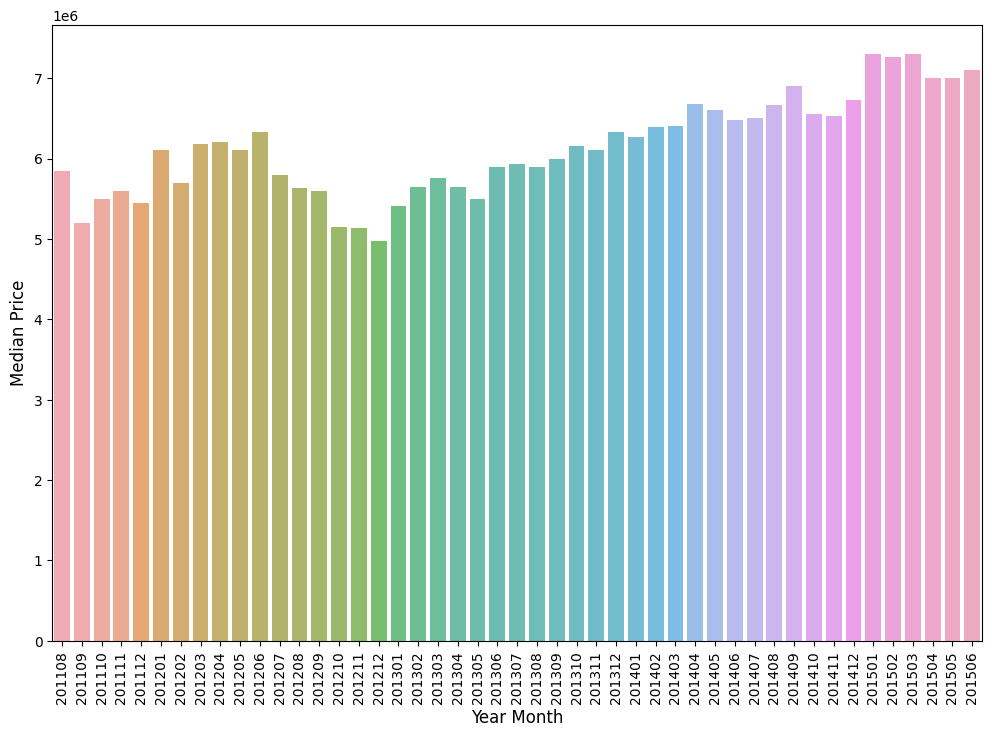

In [139]:
plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df.yearmonth.values, y=grouped_df.price_doc.values, alpha=0.8)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are some drops in 2012, but averagly there is some linear increase, so possibly we can remove timestamps and add only years

Let's check how some variables are distributed with respect to target variable.

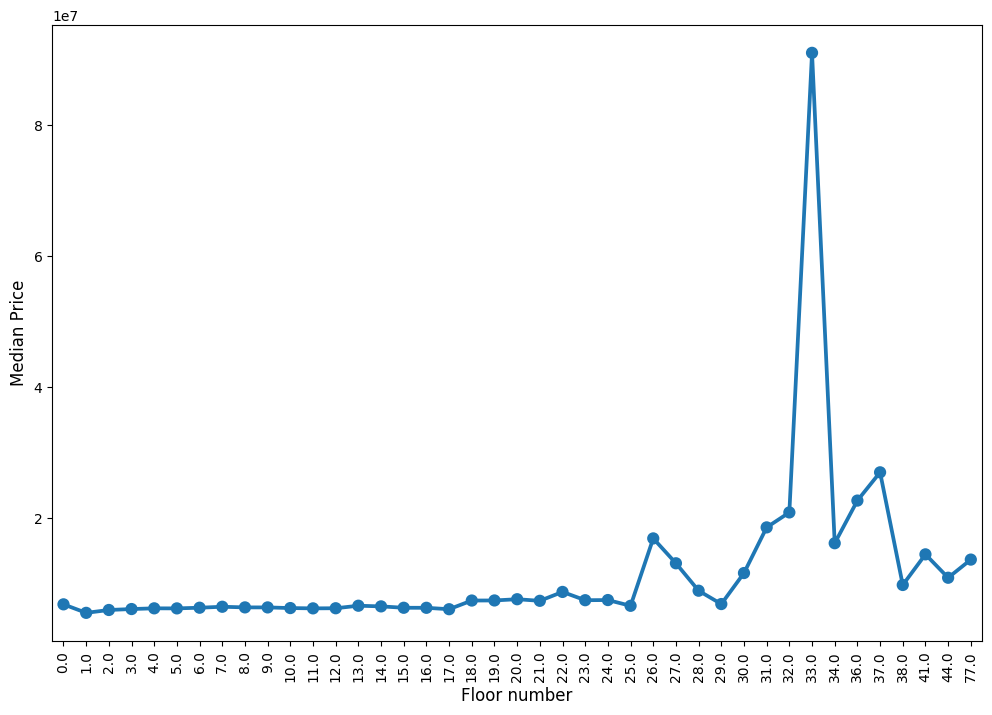

In [140]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df.floor.values, y=grouped_df.price_doc.values)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Let's check full_sq

/tmp/ipykernel_761/1972600686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['price_doc'][train_df['price_doc']>ulimit] = ulimit
/tmp/ipykernel_761/1972600686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col] > ulimit] = ulimit
/tmp/ipykernel_761/1972600686.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col] < llimit] = llimit
/home/greg/Documents/Projects/ksenofo

<Figure size 1200x1200 with 0 Axes>

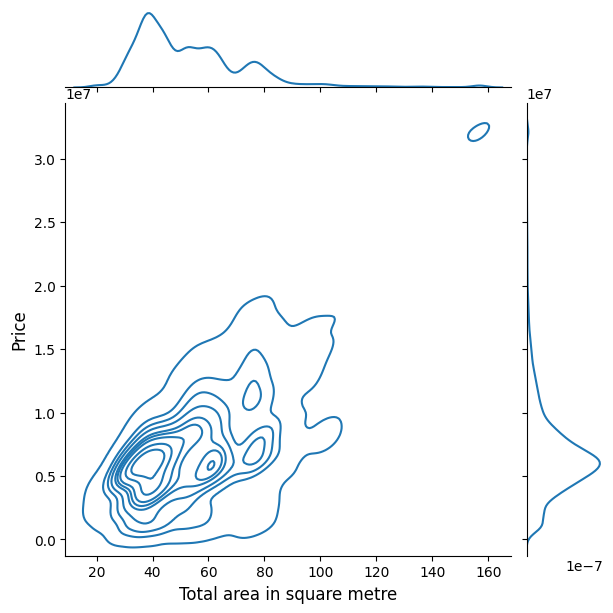

In [141]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'][train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'][train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col][train_df[col] > ulimit] = ulimit
train_df[col][train_df[col] < llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.full_sq.values, y=train_df.price_doc.values, kind='kde', size=20)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Total area in square metre', fontsize=12)
plt.show()

/tmp/ipykernel_761/2524076927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col]>ulimit] = ulimit
/tmp/ipykernel_761/2524076927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col]<llimit] = llimit
/home/greg/Documents/Projects/ksenofontov.gs/venv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'size'
  cset = contour_func(


<Figure size 1200x1200 with 0 Axes>

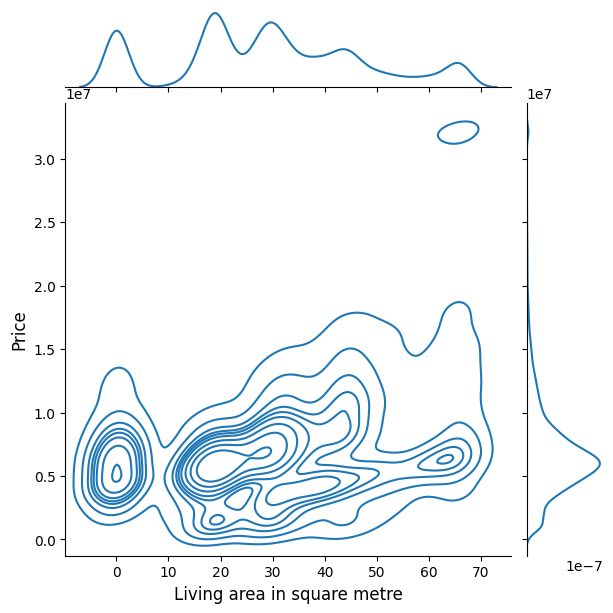

In [142]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col][train_df[col]>ulimit] = ulimit
train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.life_sq.values, y=train_df.price_doc.values, 
              kind='kde', size=10)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Living area in square metre', fontsize=12)
plt.show()

Let's check what NaNs we are left

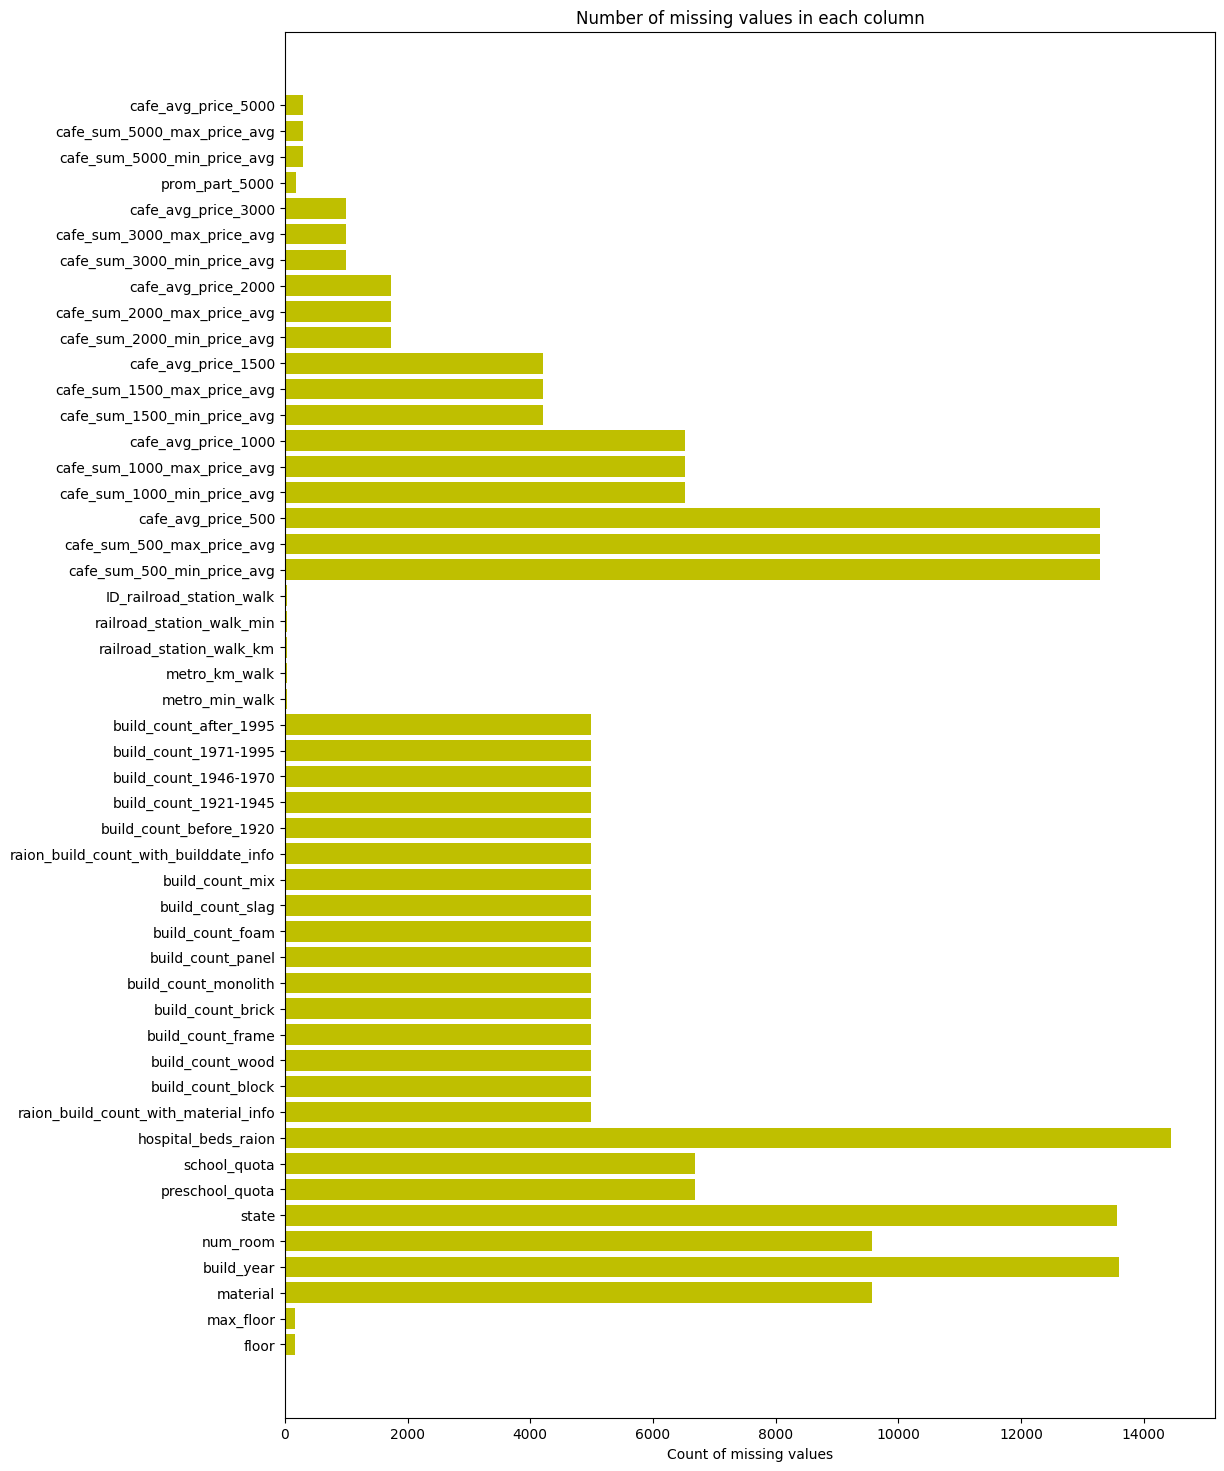

In [143]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

## Correlation analysis and feature selection

Let's make new date features

In [144]:
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year

# month of year #
train_df["month_of_year"] = train_df["timestamp"].dt.month

# week of year #
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear

# day of week #
train_df["day_of_week"] = train_df["timestamp"].dt.weekday

/tmp/ipykernel_761/826066871.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
/tmp/ipykernel_761/826066871.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear


Let's make categorical values numerical 

In [145]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))

And now train XGBoost

In [150]:

columns = train_df.drop(["id", "timestamp", "price_doc"], axis=1).columns

train, val, test = \
              np.split(train_df.sample(frac=1, random_state=42), 
                       [int(.6*len(train_df)), int(.8*len(train_df))])

X_train = train.drop(["id", "timestamp", "price_doc"], axis=1).to_numpy()
y_train = train['price_doc'].to_numpy()

X_test = test.drop(["id", "timestamp", "price_doc"], axis=1).to_numpy()
y_test = test['price_doc'].to_numpy()

X_val = val.drop(["id", "timestamp", "price_doc"], axis=1).to_numpy()
y_val = val['price_doc'].to_numpy()

In [155]:
xgb_params = {
    "objective": "reg:squarederror",
    "n_estimators":1000,
    "max_depth": 8,
    'eta': 0.01,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_lambda": 0.3,
    "random_state": 42,
    "early_stopping_rounds": 20,
}
model = xgb.XGBRegressor(**xgb_params).fit(X_train,
                                            y_train,
                                            eval_set=[(X_train, y_train) ,(X_val, y_val)],
                                            )

[0]	validation_0-rmse:8170905.33064	validation_1-rmse:8136460.45922
[1]	validation_0-rmse:8095995.93640	validation_1-rmse:8063495.85722
[2]	validation_0-rmse:8022017.65994	validation_1-rmse:7991172.29179
[3]	validation_0-rmse:7949134.83614	validation_1-rmse:7919879.26536
[4]	validation_0-rmse:7876700.56298	validation_1-rmse:7849385.56792
[5]	validation_0-rmse:7804947.25532	validation_1-rmse:7779371.74154
[6]	validation_0-rmse:7733692.96364	validation_1-rmse:7710432.03481
[7]	validation_0-rmse:7663442.93664	validation_1-rmse:7642389.77597
[8]	validation_0-rmse:7593772.08472	validation_1-rmse:7574601.13912
[9]	validation_0-rmse:7525403.97509	validation_1-rmse:7509091.98075
[10]	validation_0-rmse:7457367.03699	validation_1-rmse:7443187.94660
[11]	validation_0-rmse:7391560.39255	validation_1-rmse:7379470.68752
[12]	validation_0-rmse:7325189.40132	validation_1-rmse:7315470.64433
[13]	validation_0-rmse:7260408.27898	validation_1-rmse:7252241.11577
[14]	validation_0-rmse:7194874.17229	validat

In [156]:
model.score(X_test, y_test)

0.7000390327864927

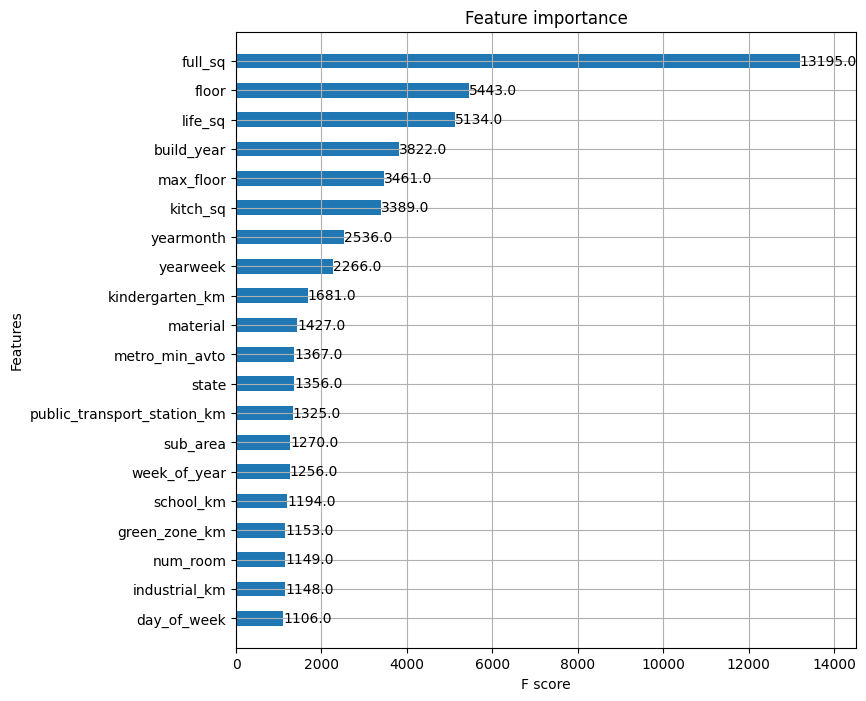

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
feature_importance = model.get_booster().get_score(importance_type='weight')
# print(dict(zip(columns, model.feature_importances_ * 1000)))
feature_importance = {column: item[1] for column, item in zip(columns, feature_importance.items())}
xgb.plot_importance(feature_importance, max_num_features=20, height=0.5, ax=ax)
plt.show()

So, we can see that full_sq, floor, life_sq, build_year and kitch_sq are the most important features